# Quickstart

Showcase for how this package can be used.

## Example data

Let's start by importing the package and getting some mock example timeseries in hourly resolution for a certain customer portfolio.

In [1]:
import portfolyo as pf
import pandas as pd
index = pd.date_range('2024', freq='H', periods=8784, tz='Europe/Berlin')

# Creating market prices (here: forward price curve) timeseries.
ts_prices = pf.dev.p_marketprices(index, avg=200)

# Creating portfolio offtake timeseries.
ts_offtake = -1 * pf.dev.w_offtake(index, avg=50)
# Creating portfolio sourced volume and prices timeseries (of quarter-products).
ts_sourced_power, ts_sourced_price = pf.dev.wp_sourced(ts_offtake, 'QS', 0.3, p_avg=120)

## Portfolio lines

By turning the timeseries into 3 "portfolio lines"...

In [2]:
hpfc = pf.PfLine({'p': ts_prices}) # price-only
offtake = pf.PfLine({'w': ts_offtake}) # volume-only
sourced = pf.PfLine({'w': ts_sourced_power, 'p': ts_sourced_price}) # price-and-volume

...it becomes easier to do common operations like plotting:

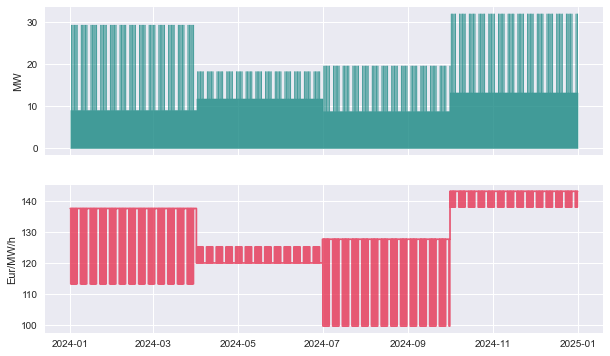

In [3]:
sourced.plot();

...aggregating:

In [4]:
sourced.asfreq('MS')

PfLine object with price and volume information.
. Timestamps: first: 2024-01-01 00:00:00+01:00     timezone: Europe/Berlin
               last: 2024-12-01 00:00:00+01:00         freq: <MonthBegin> (12 datapoints)
                                     w           q           p             r
                                    MW         MWh     Eur/MWh           Eur

2024-01-01 00:00:00 +0100         16.7      12 393      121.50     1 505 662
2024-02-01 00:00:00 +0100         16.5      11 467      121.71     1 395 635
2024-03-01 00:00:00 +0100         16.0      11 895      122.27     1 454 471
2024-04-01 00:00:00 +0200         14.2      10 250      122.33     1 253 985
2024-05-01 00:00:00 +0200         14.3      10 613      122.36     1 298 588
2024-06-01 00:00:00 +0200         14.0      10 094      122.15     1 232 955
2024-07-01 00:00:00 +0200         12.9       9 584      111.65     1 070 053
2024-08-01 00:00:00 +0200         12.7       9 453      112.13     1 060 048
2024-09-01 00:0

...or decomposing into peak- and offpeak values:

In [5]:
sourced.po('QS').pint.dequantify()  # .pint.dequantify() to show units in column header

peak                                       \
                          duration          w             q           p   
unit                             h         MW          MW·h     Eur/MWh   
2024-01-01 00:00:00+01:00    780.0  29.456518  22976.083887  113.137529   
2024-04-01 00:00:00+02:00    780.0  18.362802  14322.985695  125.067589   
2024-07-01 00:00:00+02:00    792.0  19.713694  15613.245634   99.562144   
2024-10-01 00:00:00+02:00    792.0  32.108185  25429.682473  137.871235   

                                         offpeak                           \
                                      r duration          w             q   
unit                                Eur        h         MW          MW·h   
2024-01-01 00:00:00+01:00  2.599457e+06   1403.0   9.108262  12778.891260   
2024-04-01 00:00:00+02:00  1.791341e+06   1404.0  11.847966  16634.544482   
2024-07-01 00:00:00+02:00  1.554488e+06   1416.0   8.852137  12534.625365   
2024-10-01 00:00:00+02:00  3.506022e+06   1417.0  13.283905  18823.293865   

                                                     
                                    p             r  
unit                          Eur/MWh           Eur  
2024-01-01 00:00:00+01:00  137.438362  1.756310e+06  
2024-04-01 00:00:00+02:00  119.882231  1.994186e+06  
2024-07-01 00:00:00+02:00  127.531588  1.598561e+06  
2024-10-01 00:00:00+02:00  142.971740  2.691199e+06

## Portfolio state

We can do even more useful analyses by combining the portfolio lines for offtake, sourced, and market prices into a single "portfolio state":

In [6]:
pfs = pf.PfState(offtake, hpfc, sourced)

pfs

PfState object.
. Timestamps: first: 2024-01-01 00:00:00+01:00     timezone: Europe/Berlin
               last: 2024-12-31 23:00:00+01:00         freq: <Hour> (8784 datapoints)
                                                w           q           p             r
                                               MW         MWh     Eur/MWh           Eur
──────── offtake
           2024-01-01 00:00:00 +0100        -55.6         -56                          
           2024-01-01 01:00:00 +0100        -52.5         -53                          
           ..                                  ..          ..          ..            ..
           2024-12-31 22:00:00 +0100        -66.8         -67                          
           2024-12-31 23:00:00 +0100        -63.1         -63                          
─●────── pnl_cost
 │         2024-01-01 00:00:00 +0100         55.6          56      215.36        11 982
 │         2024-01-01 01:00:00 +0100         52.5          53      203.43        10 

This object can also be resampled to other frequencies:

In [7]:
pfs_months = pfs.asfreq('MS')

We can see how much of the offtake volume is still unsourced, and how much we expect to pay for it, as a portfolio line. We can obtain it in the original frequency with `pfs.unsourced`, or in monthly frequency with `pfs_monthly.unsourced`. We can of course also chain the methods:

In [8]:
pfs.asfreq('MS').unsourced  # or: pfs.unsourced.asfreq('MS')

PfLine object with price and volume information.
. Timestamps: first: 2024-01-01 00:00:00+01:00     timezone: Europe/Berlin
               last: 2024-12-01 00:00:00+01:00         freq: <MonthBegin> (12 datapoints)
                                     w           q           p             r
                                    MW         MWh     Eur/MWh           Eur

2024-01-01 00:00:00 +0100         47.9      35 641      241.04     8 591 173
2024-02-01 00:00:00 +0100         46.7      32 515      225.99     7 348 013
2024-03-01 00:00:00 +0100         43.3      32 203      197.66     6 365 119
2024-04-01 00:00:00 +0200         40.5      29 189      178.91     5 222 026
2024-05-01 00:00:00 +0200         35.6      26 522      150.55     3 992 763
2024-06-01 00:00:00 +0200         31.7      22 791      129.29     2 946 613
2024-07-01 00:00:00 +0200         31.9      23 743      128.49     3 050 763
2024-08-01 00:00:00 +0200         33.2      24 715      138.21     3 415 769
2024-09-01 00:0

Plotting is also possible:

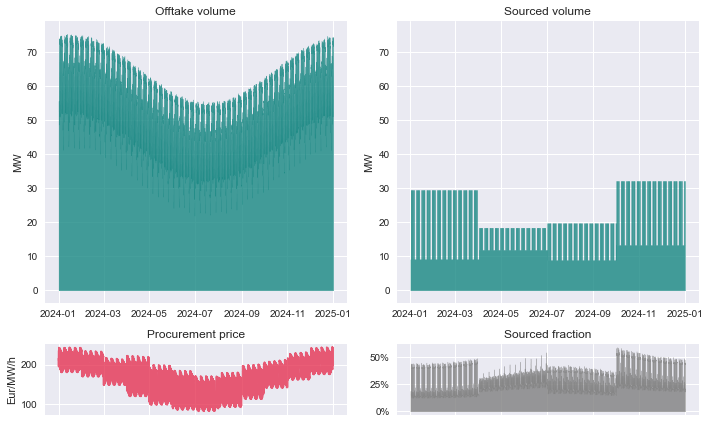

In [9]:
pfs.plot();

We can see how much it would cost to perfectly hedge the entire offtake volume, based on what has already been sourced (and its price) and what is still unsourced (valued at market prices). This is available at `pfl.pnl_cost`. Let's look at this, graphically, in month values:

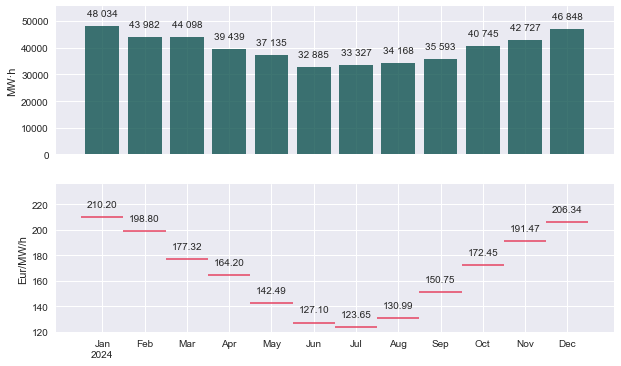

In [10]:
pfs.pnl_cost.asfreq("MS").plot();

On average, only about 30% of the portfolio has currently been hedged. This can be seen from the `pfs.plot()` output, or we can calculate the fractions explicitly:

In [11]:
pfs.asfreq('MS').sourcedfraction  # not pfs.sourcedfraction.asfreq("MS") !
# (.sourcedfraction is a pandas Series, which does not average when applying .asfreq("MS"))

2024-01-01 00:00:00+01:00     0.2579972296618051
2024-02-01 00:00:00+01:00    0.26072221704486565
2024-03-01 00:00:00+01:00     0.2697448011203642
2024-04-01 00:00:00+02:00     0.2599055982551018
2024-05-01 00:00:00+02:00    0.28579461990364363
2024-06-01 00:00:00+02:00    0.30695199203644663
2024-07-01 00:00:00+02:00     0.2875701550957839
2024-08-01 00:00:00+02:00     0.2766746760945541
2024-09-01 00:00:00+02:00     0.2559697111777357
2024-10-01 00:00:00+02:00    0.37040212201417605
2024-11-01 00:00:00+01:00     0.3348711949825904
2024-12-01 00:00:00+01:00     0.3170428046205043
Freq: MS, Name: fraction, dtype: pint[]

This means that an increase in the market prices will have a relatively large impact, especially in the months with a low sourced fraction. Let's verify that. 

First, we create a new price curve, and then create a new portfolio state with it. Then, we again look at the ``.pnl_cost`` property, to see the new procurement prices:

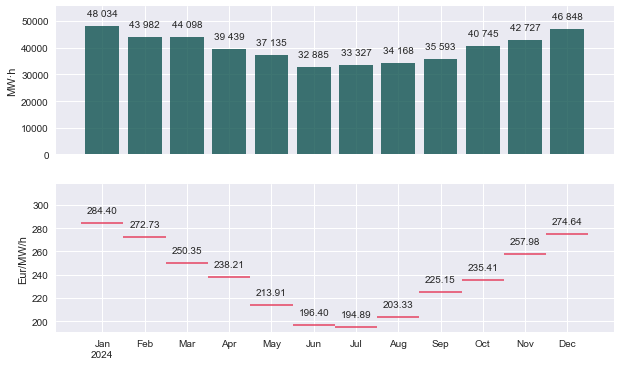

In [12]:
hpfc2 = hpfc + pf.Q_(100, "Eur/MWh")
pfs2 = pfs.set_unsourcedprice(hpfc2)
pfs2.pnl_cost.asfreq("MS").plot();

We could even explicitly calculate the monthly price increases:

In [13]:
pfs2.asfreq("MS").pnl_cost.p - pfs.asfreq("MS").pnl_cost.p

2024-01-01 00:00:00+01:00    74.20027703381916
2024-02-01 00:00:00+01:00     73.9277782955134
2024-03-01 00:00:00+01:00    73.02551988796364
2024-04-01 00:00:00+02:00    74.00944017448998
2024-05-01 00:00:00+02:00    71.42053800963544
2024-06-01 00:00:00+02:00    69.30480079635562
2024-07-01 00:00:00+02:00     71.2429844904217
2024-08-01 00:00:00+02:00     72.3325323905446
2024-09-01 00:00:00+02:00    74.40302888222635
2024-10-01 00:00:00+02:00    62.95978779858237
2024-11-01 00:00:00+01:00    66.51288050174077
2024-12-01 00:00:00+01:00    68.29571953794994
Freq: MS, Name: p, dtype: pint[Eur/MWh]

Indeed, the 100 Eur/MWh across-the-board market price increase has impacted the months exactly in proportion to the fraction that is still unsourced. So, a month that is 60% hedged sees a 40 Eur/MWh impact in its procurement price.

That's it for this quick introduction. Have a look at the more in-depth [tutorial](part1.ipynb) or the more systematic documentation of the [PfLine](../core/pfline.rst) or [PfState](../core/pfstate.rst) classes.